**Workshop**

Q: ดึงข้อมูลหุ้น Apple ปี 2020 และสร้าง MACD โดยให้ตั้งค่า parameter

Short EMA = 12 periods

Long EMA = 21 periods

Signal Line = 9 periods

และหาค่าเฉลี่ยผลกำไร ของกลยุทธ์ ฝั่ง long (หากมี position เปิดค้าง เราจะไม่นับว่าเป็นกำไร เพราะยังไม่ได้ปิด ยังไม่ใช่ realised gain)

## Import data

In [146]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import pandas_ta as ta

In [147]:
# define asset and date
ticker_name = 'AAPL'
start='2020-01-01' 
end='2021-01-01'

In [148]:
raw_df = yf.download(tickers=ticker_name, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


## Strategy

In [149]:
raw_df.ta.macd(window_fast=12, window_slow=26, window_sign=9, append=True)

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,
2020-01-02,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN
...,...,...,...
2020-12-24,3.323474,0.658064,2.665410
2020-12-28,3.794496,0.903269,2.891227
2020-12-29,3.975103,0.867101,3.108002


In [150]:
raw_df.loc[(raw_df['MACD_12_26_9'] > 0) & (raw_df['MACD_12_26_9'].shift(1) < 0), 'action'] = 'buy'
raw_df.loc[(raw_df['MACD_12_26_9'] < 0) & (raw_df['MACD_12_26_9'].shift(1) > 0), 'action'] = 'sell'

## Visualization

In [151]:
# 'col_signal' include buy and sell signal which we have to seperate the signal by our direction (side) that we pay attention.
# 'value' check the signal before add into the list

def mark_ticker(col_signal, col_price, direction):
    signal = []
    for date, value in col_signal.iteritems():
        # long side on DataFrame
        if direction == 'buy':
            if value == 'buy':
                signal.append(col_price[date] * 0.95)
            else:
                signal.append(np.nan)
        # short side on DataFrame
        elif direction == 'sell':
            if value == 'sell':
                signal.append(col_price[date] * 1.05)
            else:
                signal.append(np.nan)
    return signal

/var/folders/6t/_xyw489d5jnd7011n2m_x_ch0000gn/T/ipykernel_18216/3718644944.py:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, value in col_signal.iteritems():


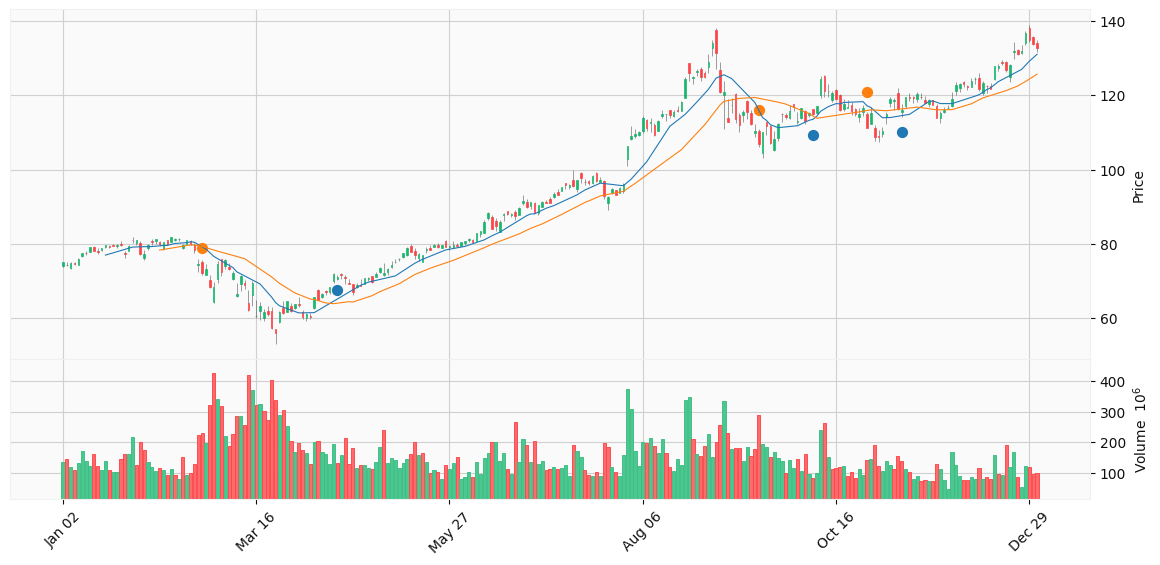

In [152]:
viz = [ mpf.make_addplot(mark_ticker(raw_df['action'], raw_df['Close'], 'buy') , type='scatter', markersize=50, marker='o'),
        mpf.make_addplot(mark_ticker(raw_df['action'], raw_df['Open'], 'sell') , type='scatter', markersize=50, marker='o')
        ]

mpf.plot(raw_df, style='yahoo', type='candle', mav=(12, 26), volume=True, addplot=viz,figsize=(15, 7))

In [153]:
raw_df[raw_df['action'].notnull()]

,Open,High,Low,Close,Adj Close,Volume,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,action
Date,,,,,,,,,,
2020-02-25,75.237503,75.632500,71.532501,72.019997,70.723816,230673600,-0.371691,-0.995220,0.623529,sell
2020-04-15,70.599998,71.582497,70.157501,71.107498,69.827744,131154400,0.249242,1.544195,-1.294953,buy
2020-09-18,110.400002,110.879997,106.089996,106.839996,105.390839,287104900,-0.627352,-2.360862,1.733510,sell
2020-10-08,116.250000,116.400002,114.589996,114.970001,113.410583,83477200,0.012185,0.271545,-0.259361,buy
2020-10-28,115.050003,115.430000,111.099998,111.199997,109.691704,143937800,-0.125056,-0.677954,0.552898,sell
2020-11-10,115.550003,117.589996,114.129997,115.970001,114.594368,138023400,0.006958,0.285354,-0.278396,buy


## Strategy Return

In [154]:
def startegy_return(df, action_price = 'Open', side='long'):
    action_df = df.loc[df['action'].notnull()]

    # action 'Open' (next day)
    if action_price == 'Open':
        action_df['action_price'] = df['Open'].shift(-1)
        action_df['return'] = action_df['action_price'].pct_change()
    
    if action_price == 'Close':
        action_df['action_price'] = df['Close']
        action_df['return'] = action_df['action_price'].pct_change()

    # record df
    record_df = action_df[['action', 'action_price', 'return']]
    record_df.reset_index(inplace=True)
    record_df['previous_signal_date'] = record_df['Date'].shift(1)
    record_df['previous_action'] = record_df['action'].shift(1)
    record_df['previous_action_price'] = record_df['action_price'].shift(1)
    record_df.rename(columns={'Date':'signal_date'}, inplace=True)

    # summary return
    if side == 'long':
        summary_df = record_df[record_df.action == 'sell']
        summary_df
    
    if side == 'short':
        summary_df = record_df[record_df.action == 'buy']
        summary_df['return'] = summary_df['return'] * -1

    summary_df.reset_index(inplace=True, drop=True)    
    
    return df, record_df, summary_df

In [155]:
df, record_df, summary_df = startegy_return(raw_df)

/var/folders/6t/_xyw489d5jnd7011n2m_x_ch0000gn/T/ipykernel_18216/2213148132.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  action_df['action_price'] = df['Open'].shift(-1)
/var/folders/6t/_xyw489d5jnd7011n2m_x_ch0000gn/T/ipykernel_18216/2213148132.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  action_df['return'] = action_df['action_price'].pct_change()
/var/folders/6t/_xyw489d5jnd7011n2m_x_ch0000gn/T/ipykernel_18216/2213148132.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [156]:
record_df

,signal_date,action,action_price,return,previous_signal_date,previous_action,previous_action_price
0,2020-02-25,sell,71.632500,NaN,NaT,None,NaN
1,2020-04-15,buy,71.845001,0.002967,2020-02-25,sell,71.632500
2,2020-09-18,sell,104.540001,0.455077,2020-04-15,buy,71.845001
3,2020-10-08,buy,115.279999,0.102736,2020-09-18,sell,104.540001
4,2020-10-28,sell,112.370003,-0.025243,2020-10-08,buy,115.279999
5,2020-11-10,buy,117.190002,0.042894,2020-10-28,sell,112.370003


In [157]:
# long side
summary_df

,signal_date,action,action_price,return,previous_signal_date,previous_action,previous_action_price
0,2020-02-25,sell,71.632500,NaN,NaT,None,NaN
1,2020-09-18,sell,104.540001,0.455077,2020-04-15,buy,71.845001
2,2020-10-28,sell,112.370003,-0.025243,2020-10-08,buy,115.279999


<AxesSubplot: >

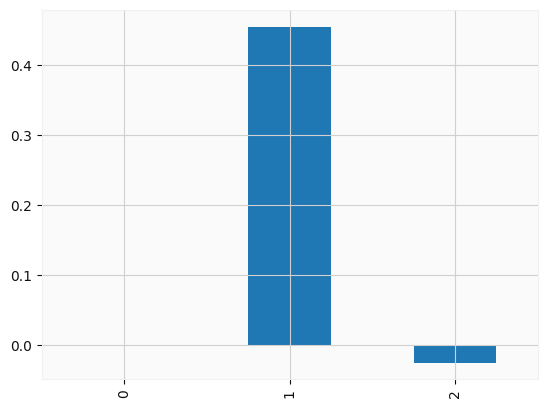

In [158]:
summary_df['return'].plot(kind='bar')

In [159]:
summary_df['return'].mean()

0.2149170184732131